In [192]:
import os 
import torch 
import torch.nn as nn 
import torch.optim as optim 
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F 
import cv2

## Introduction 

This is a simplified version of updating image over a mask region, mainly to give reader of the coder an understanding of hot to update gradient over a specific region and how the receptive field may influyence the whole things


In [193]:
# Use only first 10 layer to train the update 
model = models.vgg16(pretrained=True).features
net = nn.Sequential()
for i, layer in enumerate(list(model)):
    if i <= 9:
        net.add_module(str(len(net)), layer)
print(net)
for param in net.parameters(): # freeze new added loss layer 
    param.requires_grad = False


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


## Set Data, Target


In [194]:
def tensor_to_np_img(x):
    x_np = x.detach().numpy()
    x_np = np.squeeze(x_np, axis=0)
    x_np = np.dstack((x_np[0, :, :], x_np[1, :, :], x_np[2, :, :]))
    return x_np

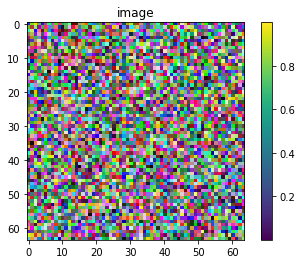

In [195]:
img = torch.rand((1, 3, 64, 64))
img = nn.Parameter(img)
plt.figure()
plt.title('image')
plt.imshow(tensor_to_np_img(img))
plt.colorbar()
plt.show()

## Simple Update using optimzier 

**NOTICE** this type of update may influence the whole receptive field 

In [196]:
optimizer = optim.Adam([img], 1e-2)

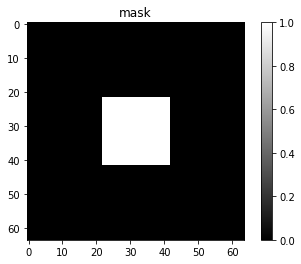

mask shape is: torch.Size([1, 1, 64, 64])


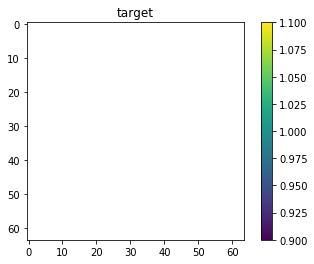

In [197]:
target = torch.ones((img.shape))
mask = torch.zeros((1, 1, img.shape[2], img.shape[3]))
mask[0, 0, 22:42, 22:42] = 1 
plt.figure()
plt.title('mask')
plt.imshow(mask[0,0,:,:], cmap='gray')
plt.colorbar()
plt.show()
print('mask shape is:',mask.shape)
plt.figure()
plt.title('target')
plt.imshow(tensor_to_np_img(target))
plt.colorbar()
plt.show()


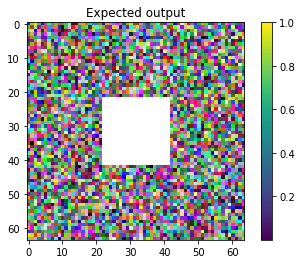

Expected output shape : torch.Size([1, 3, 64, 64])


In [198]:
expected_output = (1-mask.expand(img.shape)) * img + mask.expand(img.shape) * target
plt.figure()
plt.imshow(tensor_to_np_img(expected_output))
plt.title('Expected output')
plt.colorbar()
plt.show()
print('Expected output shape :', expected_output.shape)

In [199]:
target_fm = net(target)
print(target_fm.shape)

torch.Size([1, 128, 16, 16])


In [200]:
mask_fm = F.interpolate(mask, scale_factor=(0.25, 0.25))
mask_fm = mask_fm.expand(target_fm.shape)
print(mask_fm.shape)

torch.Size([1, 128, 16, 16])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


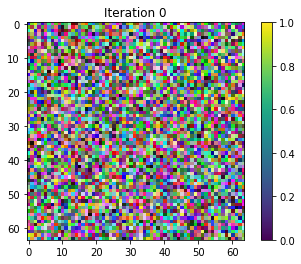

Iteration 0
Iteration 100


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


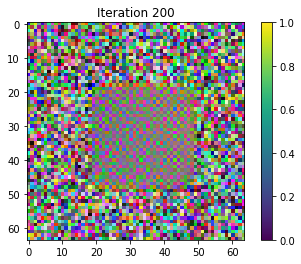

Iteration 200
Iteration 300


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


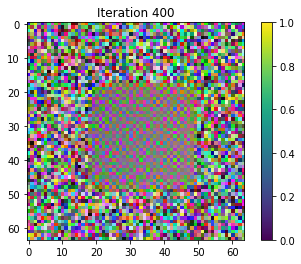

Iteration 400
Iteration 500


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


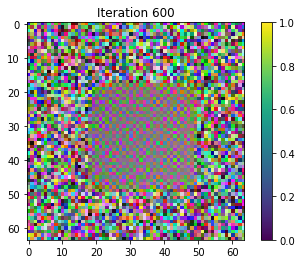

Iteration 600
Iteration 700


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


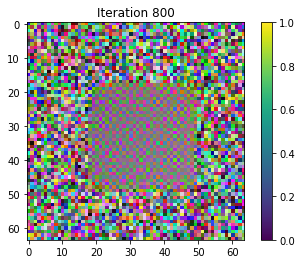

Iteration 800
Iteration 900


In [201]:
i = 0
while i < 1000:
    optimizer.zero_grad()
    img_fm = net(img)
    diff = (img_fm - target_fm)**2
    diff_mask = diff * mask_fm
    loss = torch.sum(diff_mask)
    loss.backward()
    optimizer.step()
    if i % 200 == 0:
        img_np = tensor_to_np_img(img)
        plt.imshow(img_np)
        plt.colorbar()
        plt.title('Iteration {}'.format(str(i)))
        plt.show()
    if i % 100 == 0:
        print('Iteration {}'.format(i))
    i += 1

## Mask Gradient to update

**NOTICE** this deal with the problem that the whole receptive field is updated 

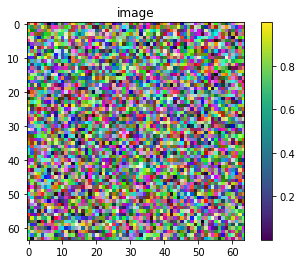

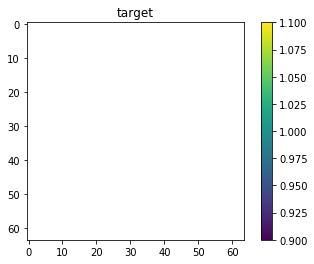

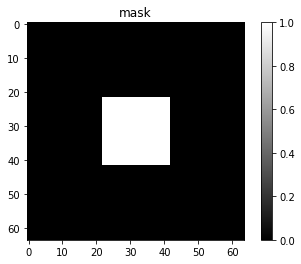

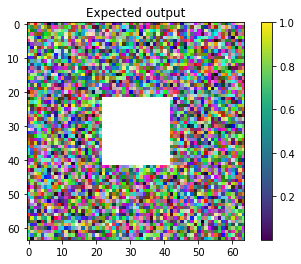

In [202]:
# Define image, mask, target like we did in the previous step 

# Image 
img = torch.rand((1, 3, 64, 64))
img = nn.Parameter(img)
plt.figure()
plt.title('image')
plt.imshow(tensor_to_np_img(img))
plt.colorbar()
plt.show()

img_fm = net(img)

# Target 
target = torch.ones((img.shape))
plt.figure()
plt.title('target')
plt.imshow(tensor_to_np_img(target))
plt.colorbar()
plt.show()

# Mask 
mask = torch.zeros((1, 1, img.shape[2], img.shape[3]))
mask[0, 0, 22:42, 22:42] = 1 
mask_img = mask.expand(img.shape)
mask_fm = F.interpolate(mask, scale_factor=(0.25, 0.25))
mask_fm = mask_fm.expand(img_fm.shape)

plt.figure()
plt.title('mask')
plt.imshow(mask[0,0,:,:], cmap='gray')
plt.colorbar()
plt.show()

# Expected output 
expected_output = (1-mask_img) * img + mask_img * target
plt.figure()
plt.imshow(tensor_to_np_img(expected_output))
plt.title('Expected output')
plt.colorbar()
plt.show()

# Target fm ( or style feature map )
target_fm = net(expected_output).detach()
target_fm.require_grad = False

In [203]:
optimizer = optim.Adam([img], 1e-2)

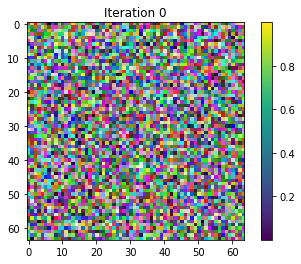

Iteration 0
Iteration 100


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


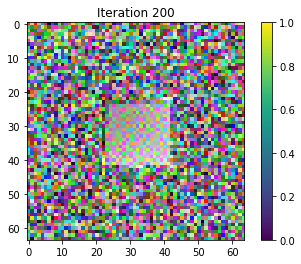

Iteration 200
Iteration 300


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


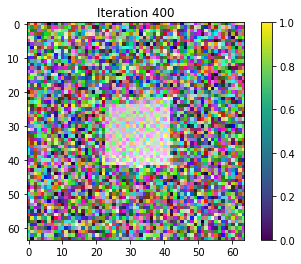

Iteration 400
Iteration 500


In [204]:
i = 0
def closure():
    optimizer.zero_grad()
    img_fm = net(img)
    diff = (img_fm - target_fm)**2
    diff_mask = diff * mask_fm
    loss = torch.sum(diff_mask)
    loss.backward()
    img.grad = img.grad * mask_img
    if i % 200 == 0:
        img_np = tensor_to_np_img(img)
        plt.imshow(img_np)
        plt.colorbar()
        plt.title('Iteration {}'.format(str(i)))
        plt.show()
    if i % 100 == 0:
        print('Iteration {}'.format(i))
    
while i < 600:
    optimizer.step(closure)
    i += 1
    

### Back Proprigation with gradient over mask for every layer 

The previous part shows updating gradient on the image over the masked region. In the original Lua code, the gradient in the network is also pass backward if it's inside the mask region. See `neural_gram.lua`, `function ContentLoss:updateGradInput(input, gradOutput)`. But because PyTorch use a different implementation than torch, backward pass is automatically computed and there's no direct way to have things like `self.gradInput:cmul(msk)` in the forward pass. There're few possible way to deal with this 

1. Register a backward hook over the ContentLoss Module 

Currently, PyTorch do not support backward hook with `complex module` (sub module inside another module) but ContentLoss contain nn.MSELoss() which makes it impossible to register a backward hook over the whole module. A possible solution is to define out own loss function by using `F.mse_loss`, which is not a `module` class 

2. Regieter a backward hook on the input tensor 

We can also register a backward hook on the input tensor and the hook will be called when gradient is backprop to the input

Two implementation will be showed below to see how it perform differently. The way to validate gradient is to use a backward hook on the layer before the loss function to check its los output 

In [205]:
img = torch.rand((1, 3, 16, 16))
img = nn.Parameter(img)
print(img.shape)

target = torch.ones((1, 3, 16, 16))
print(target.shape)

torch.Size([1, 3, 16, 16])
torch.Size([1, 3, 16, 16])


In [206]:
mask = torch.zeros((1, 1, img.shape[2], img.shape[3]))
mask[0, 0, 4:12, 4:12] = 1  # mask over 4-11, 8 pixel 
print('mask shape', mask.shape)

mask_layer_1 = torch.zeros((1, 1, 16, 16))
mask_layer_1[:, :, 4:12, 4:12] = 1 # mask over 4-11, 8 pixel 
print('mask_layer_1 shape', mask_layer_1.shape)
print('Slice of mask_layer_1 \n', mask_layer_1[0, 0, :, :])

mask_layer_2 = torch.zeros((1, 1, 8, 8))
mask_layer_2[:, :, 2:6, 2:6] = 1 # mask over 2-5, 4 pixel 
print('mask_layer_2 shape', mask_layer_2.shape)
print('Slice of mask_layer_2 \n', mask_layer_2[0, 0, :, :])



mask shape torch.Size([1, 1, 16, 16])
mask_layer_1 shape torch.Size([1, 1, 16, 16])
Slice of mask_layer_1 
 tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.],
    

In [237]:
class MyLoss(nn.Module):
    def __init__(self, layer_mask, mask_gradient=True):
        super(MyLoss, self).__init__()
        self.criterian = nn.MSELoss()
        self.mask = layer_mask.clone()
        self.mode = 'None'
        self.mask_gradient = mask_gradient
    
    def forward(self, input):
        if self.mode == 'capture':
            self.target = input.detach()
            print('ContentLoss content feature map with shape {} captured'.format(str(self.target.shape)))

            # Update Mask Size after feature map is captured 
            self.mask = self.mask.expand_as(self.target)
            print('Mask is resize to {}'.format(str(self.mask.shape)))

        elif self.mode == 'loss':
            self.loss = self.criterian(input, self.target) * 0.1
            
            if self.mask_gradient:
                def backward_variable_hook_fn(grad):

                    output = grad * self.mask 
                    '''
                    grad_slice_np = grad[0, 0, :, :].numpy()
                    output_slice_np = output[0, 0, :, :].numpy()
                    mask_slice_np = self.mask[0,0,:,:].numpy()
                    
                    plt.figure()
                    plt.imshow(grad_slice_np,cmap='gray')
                    plt.title('original gradient ')
                    plt.colorbar()
                    plt.show()

                    plt.figure()
                    plt.imshow(output_slice_np,cmap='gray')
                    plt.title('masked gradient')
                    plt.colorbar()
                    plt.show()
                    
                    plt.figure()
                    plt.imshow(mask_slice_np, cmap='gray')
                    plt.title('mask')
                    plt.colorbar()
                    plt.show()
                    '''
                    return output

                # Verifying hook can be use on input 
                input.register_hook(backward_variable_hook_fn)

        return input
    
    # 是否可以在input上register variable hook

In [216]:
def hook_print_grad_layer1(module, grad_input, grad_output):
    '''
    loss -> ... -> grad_output -> module -> grad_input -> ... -> img 
    '''
    grad_output_np = grad_output[0][0, 0, :, :].numpy()
    print(grad_output_np.shape)
    print(grad_output_np)
    plt.figure()
    plt.imshow(grad_output_np,cmap='gray')
    plt.title('gradient')
    plt.colorbar()
    plt.show()
    
    plt.figure()
    plt.imshow(mask_layer_1[0,0,:,:],cmap='gray')
    plt.title('mask')
    plt.colorbar()
    plt.show()

def hook_print_grad_layer2(module, grad_input, grad_output):
    '''
    loss -> ... -> grad_output -> module -> grad_input -> ... -> img 
    '''
    grad_output_np = grad_output[0][0, 0, :, :].numpy()
    print(grad_output_np.shape)
    print(grad_output_np)
    plt.figure()
    plt.imshow(grad_output_np,cmap='gray')
    plt.title('gradient')
    plt.colorbar()
    plt.show()

    plt.figure()
    plt.imshow(mask_layer_2[0,0,:,:],cmap='gray')
    plt.title('mask')
    plt.colorbar()
    plt.show()
    

In [217]:
model = models.vgg16(pretrained=True).features
print('Original Model', model)


Original Model Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256,

In [218]:
net = nn.Sequential()
loss_list = []
for i, layer in enumerate(list(model)):
    if i <= 8:
        net.add_module(str(len(net)), layer)
    if i == 3:
        net[-1].register_backward_hook(hook_print_grad_layer1)
        loss_layer = MyLoss(mask_layer_1)
        net.add_module(str(len(net)), loss_layer)
        loss_list.append(loss_layer)
    if i == 8:
        net[-1].register_backward_hook(hook_print_grad_layer2)
        loss_layer = MyLoss(mask_layer_2)
        net.add_module(str(len(net)), loss_layer)
        loss_list.append(loss_layer)
print(net)
for param in net.parameters(): # freeze new added loss layer 
    param.requires_grad = False
    

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MyLoss(
    (criterian): MSELoss()
  )
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): MyLoss(
    (criterian): MSELoss()
  )
)


In [219]:
from torchsummary import summary
summary(net, (3, 16, 16))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           1,792
              ReLU-2           [-1, 64, 16, 16]               0
            Conv2d-3           [-1, 64, 16, 16]          36,928
              ReLU-4           [-1, 64, 16, 16]               0
            MyLoss-5           [-1, 64, 16, 16]               0
         MaxPool2d-6             [-1, 64, 8, 8]               0
            Conv2d-7            [-1, 128, 8, 8]          73,856
              ReLU-8            [-1, 128, 8, 8]               0
            Conv2d-9            [-1, 128, 8, 8]         147,584
             ReLU-10            [-1, 128, 8, 8]               0
           MyLoss-11            [-1, 128, 8, 8]               0
Total params: 260,160
Trainable params: 0
Non-trainable params: 260,160
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [220]:
for i in loss_list:
    i.mode = 'capture'
out = net(target)

ContentLoss content feature map with shape torch.Size([1, 64, 16, 16]) captured
Mask is resize to torch.Size([1, 64, 16, 16])
ContentLoss content feature map with shape torch.Size([1, 128, 8, 8]) captured
Mask is resize to torch.Size([1, 128, 8, 8])


In [221]:
for i in loss_list:
    i.mode = 'loss'
out = net(img)

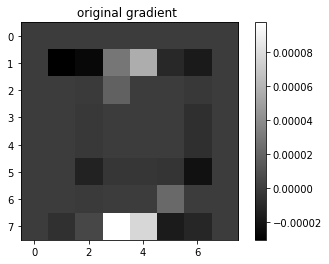

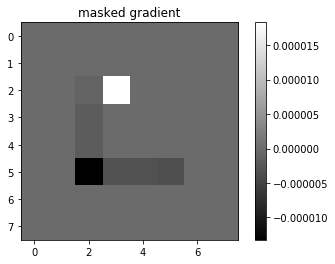

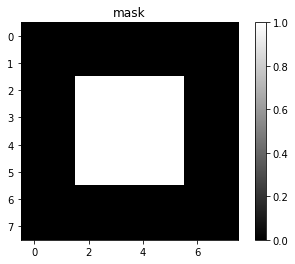

(8, 8)
[[ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -0.0000000e+00 -0.0000000e+00  0.0000000e+00
   0.0000000e+00 -0.0000000e+00 -0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -1.0284590e-06  1.8312900e-05
   0.0000000e+00  0.0000000e+00 -0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -1.7952191e-06  0.0000000e+00
   0.0000000e+00  0.0000000e+00 -0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -1.7952191e-06  0.0000000e+00
   0.0000000e+00  0.0000000e+00 -0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -1.3249237e-05 -3.1262066e-06
  -3.1262066e-06 -3.6106223e-06 -0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00 -0.0000000e+00 -0.0000000e+00  0.000000

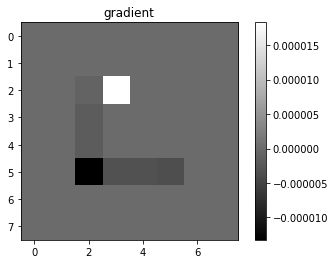

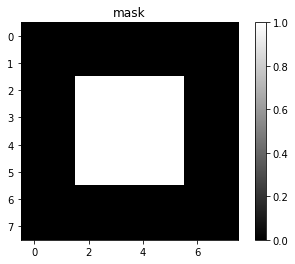

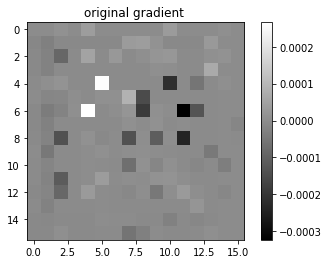

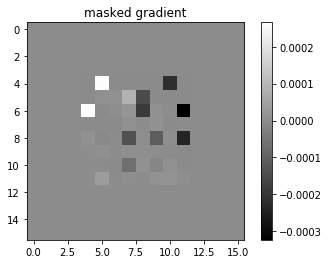

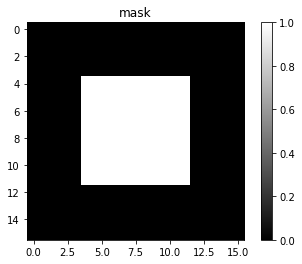

(16, 16)
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
   0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00
  -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+0

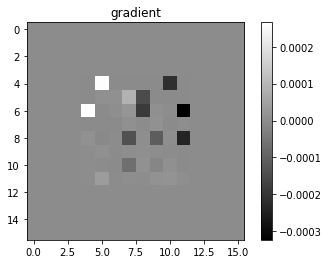

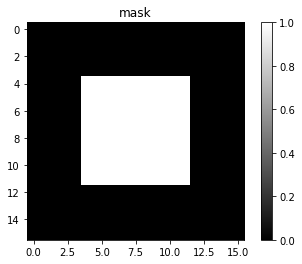

In [222]:
total_loss = 0
for i in loss_list:
    total_loss += i.loss
total_loss.backward()

### Compare two type of gradient update

**NOTICE** This part have not yet finish

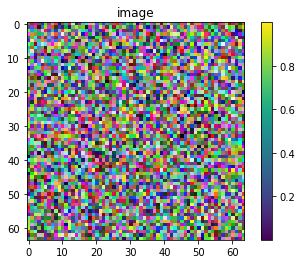

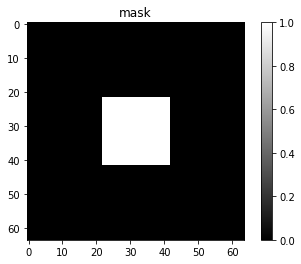

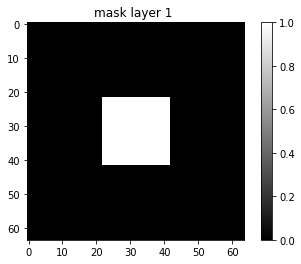

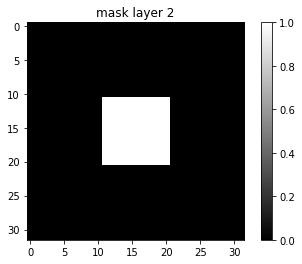

In [238]:
# Image 
img = torch.rand((1, 3, 64, 64))
img = nn.Parameter(img)
plt.figure()
plt.title('image')
plt.imshow(tensor_to_np_img(img))
plt.colorbar()
plt.show()


# Mask 
mask = torch.zeros((1, 1, img.shape[2], img.shape[3]))
mask[0, 0, 22:42, 22:42] = 1 
mask_img = mask.expand_as(img)

plt.figure()
plt.title('mask')
plt.imshow(mask[0,0,:,:], cmap='gray')
plt.colorbar()
plt.show()

mask_layer_1 = mask 
mask_layer_2 = torch.zeros((1, 1, 32, 32))
mask_layer_2[0, 0, 11:21, 11:21] = 1 

plt.figure()
plt.title('mask layer 1 ')
plt.imshow(mask_layer_1[0,0,:,:], cmap='gray')
plt.colorbar()
plt.show()

plt.figure()
plt.title('mask layer 2')
plt.imshow(mask_layer_2[0,0,:,:], cmap='gray')
plt.colorbar()
plt.show()


In [239]:
def hook_print_gradient(module, grad_input, grad_output):
    '''
    loss -> ... -> grad_output -> module -> grad_input -> ... -> img 
    '''
    grad_output_np = grad_output[0][0, 0, :, :].numpy()
    print(grad_output_np.shape)
    plt.figure()
    plt.imshow(grad_output_np,cmap='gray')
    plt.title('bp gradient')
    plt.colorbar()
    plt.show()

In [245]:
# Network without mask over gradient 
model = models.vgg16(pretrained=True).features

net_w_mask_gradient = nn.Sequential()
loss_list_w_mask_gradient = []
for i, layer in enumerate(list(model)):
    if i <= 8:
        net_w_mask_gradient.add_module(str(len(net_w_mask_gradient)), layer)
    if i == 3:
        #net_w_mask_gradient[-1].register_backward_hook(hook_print_gradient)
        loss_layer = MyLoss(mask_layer_1)
        net_w_mask_gradient.add_module(str(len(net_w_mask_gradient)), loss_layer)
        loss_list_w_mask_gradient.append(loss_layer)
    if i == 8:
        #net_w_mask_gradient[-1].register_backward_hook(hook_print_gradient)
        loss_layer = MyLoss(mask_layer_2)
        net_w_mask_gradient.add_module(str(len(net_w_mask_gradient)), loss_layer)
        loss_list_w_mask_gradient.append(loss_layer)

print('net with mask gradient :', net_w_mask_gradient)
for param in net_w_mask_gradient.parameters(): # freeze new added loss layer 
    param.requires_grad = False
    
# Network with mask over gradient 
net_n_mask_gradient = nn.Sequential()
loss_list_n_mask_gradient = []
for i, layer in enumerate(list(model)):
    if i <= 8:
        net_n_mask_gradient.add_module(str(len(net_n_mask_gradient)), layer)
    if i == 3:
        #net_n_mask_gradient[-1].register_backward_hook(hook_print_gradient)
        loss_layer = MyLoss(mask_layer_1, mask_gradient=False)
        net_n_mask_gradient.add_module(str(len(net_n_mask_gradient)), loss_layer)
        loss_list_n_mask_gradient.append(loss_layer)
    if i == 8:
        #net_n_mask_gradient[-1].register_backward_hook(hook_print_gradient)
        loss_layer = MyLoss(mask_layer_2, mask_gradient=False)
        net_n_mask_gradient.add_module(str(len(net_n_mask_gradient)), loss_layer)
        loss_list_n_mask_gradient.append(loss_layer)
print('net without mask gradient', net_n_mask_gradient)
for param in net_n_mask_gradient.parameters(): # freeze new added loss layer 
    param.requires_grad = False
    

net with mask gradient : Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MyLoss(
    (criterian): MSELoss()
  )
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): MyLoss(
    (criterian): MSELoss()
  )
)
net without mask gradient Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MyLoss(
    (criterian): MSELoss()
  )
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(64, 128, ke

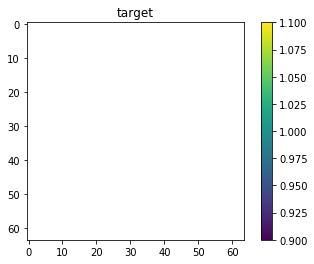

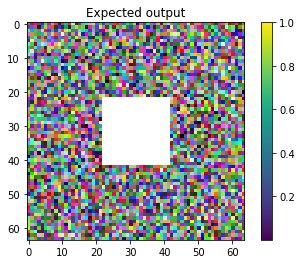

In [246]:
# Target 
target = torch.ones((img.shape))
plt.figure()
plt.title('target')
plt.imshow(tensor_to_np_img(target))
plt.colorbar()
plt.show()

# Expected output 
expected_output = (1-mask_img) * img + mask_img * target
plt.figure()
plt.imshow(tensor_to_np_img(expected_output))
plt.title('Expected output')
plt.colorbar()
plt.show()

# Target fm ( or style feature map )
target_fm = net_n_mask_gradient(expected_output).detach()
target_fm.require_grad = False

In [247]:
for i in loss_list_w_mask_gradient:
    i.mode = 'capture'
out = net_w_mask_gradient(target)

for i in loss_list_n_mask_gradient:
    i.mode = 'capture'
out = net_n_mask_gradient(target)

for i in loss_list_w_mask_gradient:
    i.mode = 'loss'

for i in loss_list_n_mask_gradient:
    i.mode = 'loss'


ContentLoss content feature map with shape torch.Size([1, 64, 64, 64]) captured
Mask is resize to torch.Size([1, 64, 64, 64])
ContentLoss content feature map with shape torch.Size([1, 128, 32, 32]) captured
Mask is resize to torch.Size([1, 128, 32, 32])
ContentLoss content feature map with shape torch.Size([1, 64, 64, 64]) captured
Mask is resize to torch.Size([1, 64, 64, 64])
ContentLoss content feature map with shape torch.Size([1, 128, 32, 32]) captured
Mask is resize to torch.Size([1, 128, 32, 32])


In [248]:
optimizer1 = optim.Adam([img], 1e-2)
optimizer2 = optim.Adam([img], 1e-2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


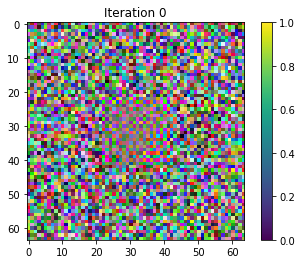

Iteration 0
Iteration 100


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


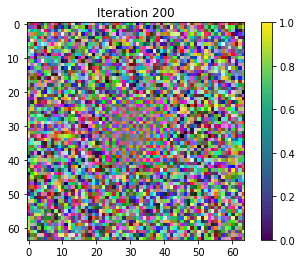

Iteration 200
Iteration 300


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


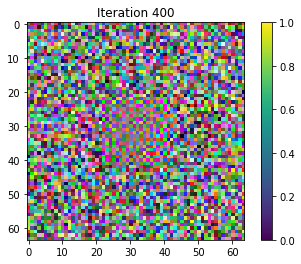

Iteration 400
Iteration 500


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


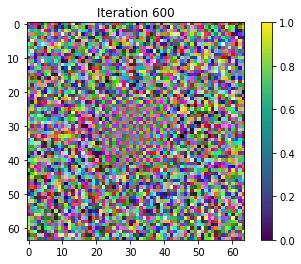

Iteration 600
Iteration 700


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


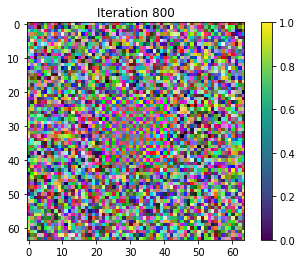

Iteration 800
Iteration 900


In [251]:
i_iter = 0
def closure():
    optimizer1.zero_grad()
    img_fm = net_w_mask_gradient(img)
    total_loss = 0
    for i in loss_list_w_mask_gradient:
        total_loss += i.loss
    total_loss.backward()
    
    img.grad = img.grad * mask_img
    
    if i_iter % 200 == 0:
        img_np = tensor_to_np_img(img)
        plt.imshow(img_np)
        plt.colorbar()
        plt.title('Iteration {}'.format(str(i_iter)))
        plt.show()
    if i_iter % 100 == 0:
        print('Iteration {}'.format(i_iter))
    
while i_iter < 1000:
    optimizer1.step(closure)
    i_iter += 1
    